# Visualiazation Experiments

This notebook is a an exploratory work on what visualizations for Gutenberg project statistics data ([sample](https://github.com/leomrocha/mix_nlp/tree/master/gutenberg_stats_examples)) could be interesting too look at. It also contains some experiments on what library to use when building visualizations from existing data and how.

In [1]:
EXAMPLE_DIR = '../../gutenberg_stats_examples/'

In [2]:
# data is stored as json, lots of nesting

import gzip
import json    

with gzip.open(f'{EXAMPLE_DIR}/2568-0.stats_all.json.gz', "rb") as f:
    trents_last_case = json.loads(f.read())
    
trents_last_case.keys()

dict_keys(['metadata', 'file_stats', 'stats_data', 'tokens'])

In [3]:
# save as different files to explore separately

for stat in trents_last_case.keys():
    with open(f"../../gutenberg_stats_examples/2568-0/{stat}.json", "w") as f:
        json.dump(trents_last_case[stat], f, indent=2)

In [4]:
import pandas as pd

words_by_sentence = pd.Series(trents_last_case['stats_data']['by_sentence']['word_length'])
words_by_paragraph = pd.Series(trents_last_case['stats_data']['by_paragraph']['word_length'])

In [5]:
words_by_sentence.index

Index(['2', '1', '0', '6', '31', '10', '9', '3', '44', '18', '15', '24', '21',
       '11', '12', '5', '7', '4', '17', '23', '8', '13', '14', '16', '26',
       '25', '35', '19', '29', '33', '20', '22', '27', '30', '28', '34', '43',
       '75', '40', '37', '32'],
      dtype='object')

In [6]:
sentence_wc = words_by_sentence
sentence_wc.index = sentence_wc.index.astype('int64')
sentence_wc.sort_index(inplace=True)
sentence_wc = sentence_wc[1:]
sentence_wc

1     470
2     607
3     564
4     542
5     459
6     406
7     336
8     269
9     229
10    185
11    156
12    106
13     90
14     73
15     59
16     44
17     33
18     32
19     18
20     19
21      3
22     13
23     10
24      6
25      8
26      7
27      1
28      3
29      2
30      2
31      2
32      1
33      2
34      1
35      1
37      1
40      1
43      1
44      1
75      1
dtype: int64

In [7]:
x = sentence_wc.index.values
y = sentence_wc.values

## Finding the library

### Seaborn

This library is Python-only, does not have any interactivity, suits for publishing notebooks directly (without a webapp at all). It's easy to use with raw data (when no statistics are calculated yet), but because the data we have is already computed statistics, not so useful.

Onhover behavior can be added with additional library [mplcursors](https://stackoverflow.com/a/61337574/9076659)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")

In [9]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

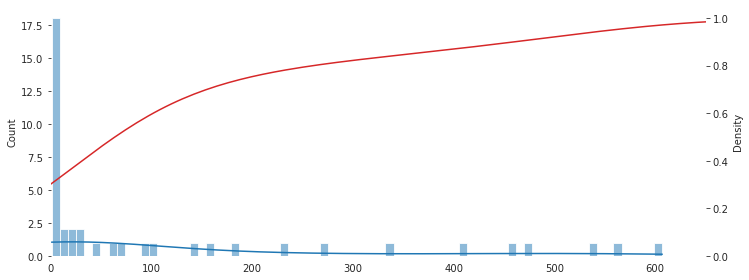

In [10]:
# (failed attempt) tried to use seaborn in an easy way
# the difficulty is seaborn expects raw data from
# which it itself calculates the frequency, but we already have a frequency
# the plot is not correct

# histogram and KDE
sns.displot(words_by_sentence, bins=75, kde=True, height=4, aspect=2.5)
ax = plt.twinx() # add second y axis 
ax.set_xlim(0, 650)

# CDF 
sns.kdeplot(
    data=words_by_sentence, cumulative=True, 
    ax=ax, color=sns.color_palette()[3]
)
sns.despine(left=True, bottom=True)
plt.show()

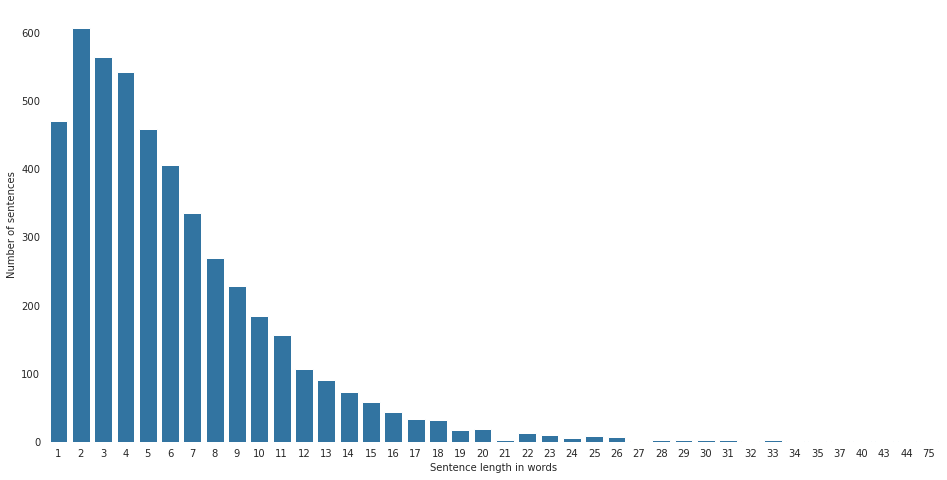

In [11]:
# to be able to graph from existing frequency need to use bar chart
plt.figure(figsize=(16,8))
ax = sns.barplot(x=x, y=y, color=sns.color_palette()[0])
sns.despine(left=True, bottom=True)
plt.xlabel('Sentence length in words')
plt.ylabel('Number of sentences')
plt.show()

### Chartify

https://github.com/spotify/chartify

Basically suffers from the same as seaborn - tries to compute everything itself, including frequency tables. [docs](https://chartify.readthedocs.io/en/latest/usage.html#chartify._core.plot.PlotNumericDensityXY). A downside is that the API for that library is very much unlike the one for matplotlib / seaborn, maybe because it's based on bokeh.

From the upside - may be extended with bokeh when needed.

In [12]:
# a very simple usage does not work

# import chartify

# ch = chartify.Chart(x_axis_type='categorical')

# ch.set_title("Title")
# ch.set_subtitle("Subtitle")
# ch.plot.bar(
#     data_frame=pd.DataFrame(sentence_wc),
# #     categorical_columns='fruit',
# #     numeric_column='quantity',
# #     categorical_order_by='labels',
# #     categorical_order_ascending=True
# )

### Bokeh

In [28]:
import numpy as np

from bokeh.layouts import gridplot

from bokeh.plotting import figure, show
from bokeh.io import output_notebook, show

from bokeh.models import LinearAxis, Range1d

In [14]:
output_notebook()

Loading BokehJS ...

In [15]:
# example from https://docs.bokeh.org/en/latest/docs/gallery/histogram.html

import scipy.special

def make_plot(title, hist, edges, x, pdf, cdf):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
    p.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend_label="PDF")
    p.line(x, cdf, line_color="orange", line_width=2, alpha=0.7, legend_label="CDF")

    p.y_range.start = 0
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'x'
    p.yaxis.axis_label = 'Pr(x)'
    p.grid.grid_line_color="white"
    return p

# Normal Distribution

mu, sigma = 0, 0.5

measured = np.random.normal(mu, sigma, 1000)
hist, edges = np.histogram(measured, density=True, bins=50)

x = np.linspace(-2, 2, 1000)
pdf = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2*sigma**2))
cdf = (1+scipy.special.erf((x-mu)/np.sqrt(2*sigma**2)))/2

p1 = make_plot("Normal Distribution (μ=0, σ=0.5)", hist, edges, x, pdf, cdf)

show(gridplot([p1], ncols=2, plot_width=400, plot_height=400, toolbar_location=None))

In [29]:
# Note the calculations are most likely not correct
# they are present only as approximation to explore visualizations

# TODO: fix double y axis, https://stackoverflow.com/questions/25199665/one-chart-with-two-different-y-axis-ranges-in-bokeh

def make_plot(title, hist, edges, x, pdf, cdf):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
    
    
    p.extra_y_ranges = {"foo": Range1d(start=0, end=1)}
    p.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend_label="PDF")
    p.line(x, cdf, line_color="orange", line_width=2, alpha=0.7, legend_label="CDF")

    p.y_range.start = 0
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'x'
    p.yaxis.axis_label = 'Pr(x)'
    p.grid.grid_line_color="white"
    return p

# Normal Distribution

mu, sigma = 0, 0.5

measured = sentence_wc.values
hist = measured

# hist, edges = np.histogram(measured, density=True, bins=50)

x = sentence_wc.index.values
_, edges = np.histogram(x, density=True, bins=80)

pdf = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2*sigma**2))
cdf = (1+scipy.special.erf((x-mu)/np.sqrt(2*sigma**2)))/2

p1 = make_plot("Normal Distribution (μ=0, σ=0.5)", hist, edges, x, pdf, cdf)

show(p1)

In [25]:
edges

array([  1.  ,  13.12,  25.24,  37.36,  49.48,  61.6 ,  73.72,  85.84,
        97.96, 110.08, 122.2 , 134.32, 146.44, 158.56, 170.68, 182.8 ,
       194.92, 207.04, 219.16, 231.28, 243.4 , 255.52, 267.64, 279.76,
       291.88, 304.  , 316.12, 328.24, 340.36, 352.48, 364.6 , 376.72,
       388.84, 400.96, 413.08, 425.2 , 437.32, 449.44, 461.56, 473.68,
       485.8 , 497.92, 510.04, 522.16, 534.28, 546.4 , 558.52, 570.64,
       582.76, 594.88, 607.  ])

In [18]:
hist

array([0.04125413, 0.00412541, 0.00412541, 0.00206271, 0.00206271,
       0.00206271, 0.        , 0.00206271, 0.00206271, 0.        ,
       0.        , 0.        , 0.00206271, 0.        , 0.        ,
       0.00206271, 0.        , 0.        , 0.00206271, 0.        ,
       0.        , 0.        , 0.00206271, 0.        , 0.        ,
       0.        , 0.        , 0.00206271, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00206271, 0.        ,
       0.        , 0.        , 0.00206271, 0.00206271, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00206271,
       0.        , 0.00206271, 0.        , 0.        , 0.00206271])

In [19]:
np.histogram(measured, density=True, bins=50)

(array([0.04125413, 0.00412541, 0.00412541, 0.00206271, 0.00206271,
        0.00206271, 0.        , 0.00206271, 0.00206271, 0.        ,
        0.        , 0.        , 0.00206271, 0.        , 0.        ,
        0.00206271, 0.        , 0.        , 0.00206271, 0.        ,
        0.        , 0.        , 0.00206271, 0.        , 0.        ,
        0.        , 0.        , 0.00206271, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00206271, 0.        ,
        0.        , 0.        , 0.00206271, 0.00206271, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00206271,
        0.        , 0.00206271, 0.        , 0.        , 0.00206271]),
 array([  1.  ,  13.12,  25.24,  37.36,  49.48,  61.6 ,  73.72,  85.84,
         97.96, 110.08, 122.2 , 134.32, 146.44, 158.56, 170.68, 182.8 ,
        194.92, 207.04, 219.16, 231.28, 243.4 , 255.52, 267.64, 279.76,
        291.88, 304.  , 316.12, 328.24, 340.36, 352.48, 364.6 , 376.72,
        388.84, 400.96, 413.08

In [20]:
pdf

array([1.07981933e-001, 2.67660452e-004, 1.21517657e-008, 1.01045422e-014,
       1.53891973e-022, 4.29276747e-032, 2.19321312e-043, 2.05232615e-056,
       3.51749909e-071, 1.10418967e-087, 6.34856311e-106, 6.68542888e-126,
       1.28945199e-147, 4.55515496e-171, 2.94729227e-196, 3.49273251e-223,
       7.58105280e-252, 3.01380944e-282, 2.19444210e-314, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [21]:
cdf

array([0.97724987, 0.99996833, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [22]:
sentence_wc.index.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 37, 40, 43, 44, 75])